# Hyperparameters setup and data preparation

In [8]:
from pandas.core.computation.pytables import TermValue
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch

torch.manual_seed(3)

batch_size = 32
input_size = 11
output_size = 4
hidden_size = 100
batch_norm = False
lr = 0.01

class BodyperformanceDataset(Dataset):
  def __init__(self):
    df = pd.read_csv('bodyPerformance.csv')
    df["gender"] = np.where(df["gender"] == "M", 1, 0)
    df['class'] = df['class'].apply(lambda x: ord(x)-65)
    self.n_samples = len(df)
    self.x_data = torch.from_numpy(df.values[:,:-1].astype(np.float32))
    self.y_data = torch.from_numpy(df.values[:,-1].astype(np.int64))

  def __getitem__(self, index):
      return self.x_data[index], self.y_data[index]

  def __len__(self):
      return self.n_samples

dataset = BodyperformanceDataset()

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=TermValue)

# Prepearing the model

In [9]:
import torch.nn as nn
torch.manual_seed(3)



class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, batch_norm):
        super().__init__()
        if batch_norm:
          self.linear_stack = nn.Sequential(
              nn.Linear(input_size, hidden_size, bias=False), nn.BatchNorm1d(hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size, bias=False), nn.BatchNorm1d(hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size, bias=False), nn.BatchNorm1d(hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size, bias=False), nn.BatchNorm1d(hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size, bias=False), nn.BatchNorm1d(hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, output_size, bias = False), nn.BatchNorm1d(output_size)
          )
        else:
          self.linear_stack = nn.Sequential(
              nn.Linear(input_size, hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, hidden_size),  nn.Tanh(),
              nn.Linear(hidden_size, hidden_size), nn.Tanh(),
              nn.Linear(hidden_size, output_size)
          )

    def init_weights(self, m):
      if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='tanh')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0.)

    def kaiming_normal_init(self):
      self.apply(self.init_weights)

    def forward(self, x):
      logits = self.linear_stack(x)
      return logits



model = NeuralNetwork(input_size=input_size, output_size=output_size, hidden_size=hidden_size,
                      batch_norm=batch_norm)
model.kaiming_normal_init()

optimizer = torch.optim.SGD(model.parameters(), lr = lr)
loss_fn = nn.CrossEntropyLoss()

# Training

In [10]:
torch.manual_seed(3)

n_epochs = 5
lossi = []
ud = []

for epoch in range(n_epochs):
    model.train()
    tcorrect = 0.
    for i, data in enumerate(train_loader):
        X, y = data
        output = model(X)
        loss = loss_fn(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print (f'Epoch [{epoch+1}/{n_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss:.6f}')

        lossi.append(loss.log10().item())
        with torch.no_grad():
          next_ud = [((lr*layer.weight.grad).std()/ layer.weight.std()).log10().item() for layer in model.linear_stack if isinstance(layer, nn.Linear)]
          ud.append(next_ud)

          # calculate train accuracy
          _, predicted = torch.max(output, 1)
          tcorrect += (predicted == y).sum().item()
    with torch.no_grad():
        accuracy  =  tcorrect/len(train_dataset) * 100
        print(f'Epoch [{epoch+1}/{n_epochs}] train accuracy: {accuracy}%')

Epoch [1/5] train accuracy: 44.09184244913198%
Epoch [2/5] train accuracy: 46.46257233526227%
Epoch [3/5] train accuracy: 42.841142430464814%
Epoch [4/5] train accuracy: 43.475826022027256%
Epoch [5/5] train accuracy: 42.90647750606683%


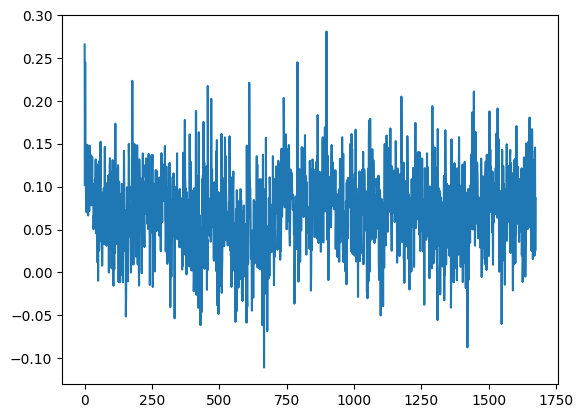

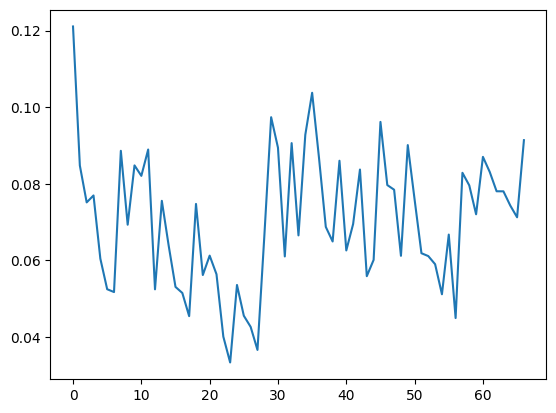

In [11]:
import matplotlib.pyplot as plt

plt.plot(lossi)
plt.show()
plt.plot(torch.tensor(lossi).view(-1,25).mean(1))
plt.show()

# Save activations and their gradients

In [12]:
activation = {}
def get_forward(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_backward(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

i = 0
for layer in model.linear_stack:
  if isinstance(layer, nn.Tanh):
    layer.register_forward_hook(get_forward('forward_activation' + str(i)))
    layer.register_backward_hook(get_backward('backward_activation' + str(i)))
    i += 1


out = model(X)
loss = loss_fn(out, y)
optimizer.zero_grad()
loss.backward()

# Visualizations of model statistics



layer 0 (      ReLU): mean -0.09, std 1.00, saturated: 99.73%
layer 1 (      ReLU): mean -0.03, std 0.77, saturated: 23.04%
layer 2 (      ReLU): mean +0.05, std 0.73, saturated: 14.15%
layer 3 (      ReLU): mean -0.02, std 0.73, saturated: 9.27%
layer 4 (      ReLU): mean -0.00, std 0.72, saturated: 9.77%


Text(0.5, 1.0, 'activation distribution')

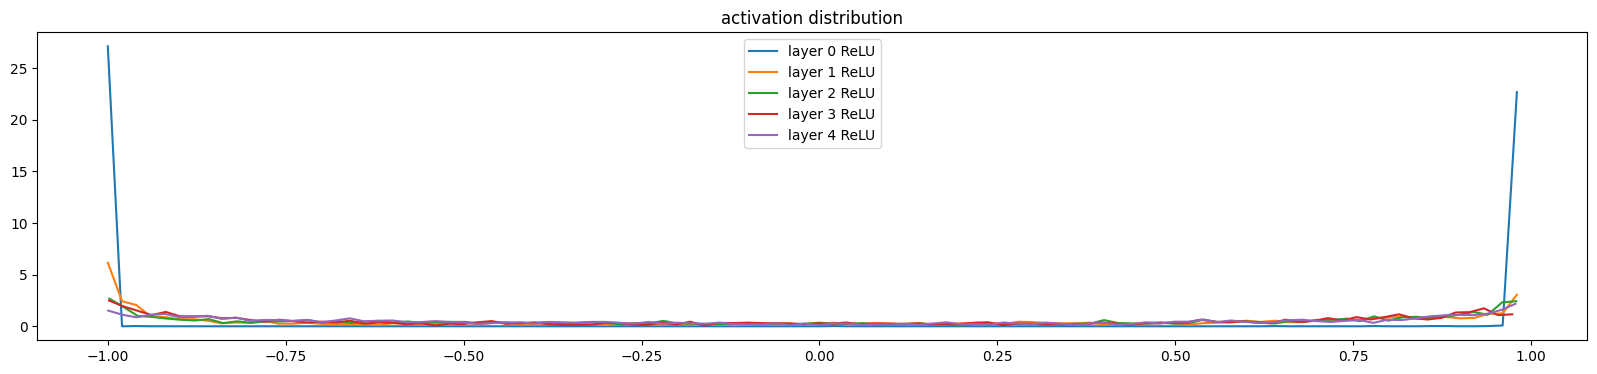

In [13]:
plt.figure(figsize=(20, 4))
legends = []

for i, key in enumerate(activation.keys()):
    if i == 5:
      break
    t = activation[key]
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, 'ReLU', t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ReLU')
plt.legend(legends);
plt.title('activation distribution')

In [14]:
activation.keys()

dict_keys(['forward_activation0', 'forward_activation1', 'forward_activation2', 'forward_activation3', 'forward_activation4', 'backward_activation4', 'backward_activation3', 'backward_activation2', 'backward_activation1', 'backward_activation0'])

layer 4 (      Tanh): mean -0.000135, std 4.972565e-03
layer 3 (      Tanh): mean +0.000058, std 4.085731e-03
layer 2 (      Tanh): mean -0.000137, std 3.869103e-03
layer 1 (      Tanh): mean -0.000036, std 3.988575e-03
layer 0 (      Tanh): mean +0.000008, std 4.442395e-03


Text(0.5, 1.0, 'gradient distribution')

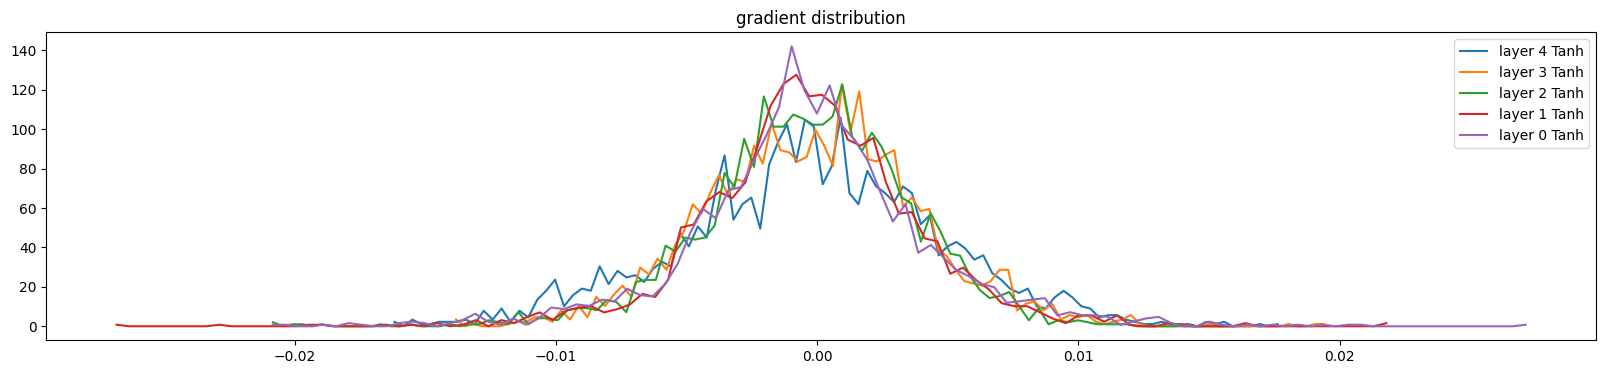

In [15]:
plt.figure(figsize=(20, 4))
legends = []

for key in activation.keys():
  if key[0] == 'f':
        continue
  t = activation[key]
  print('layer %d (%10s): mean %+f, std %e' % (int(key[-1]), 'Tanh', t.mean(), t.std()))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'layer {key[-1]} Tanh')
plt.legend(legends);
plt.title('gradient distribution')

In [16]:
# get weights and weight gradients from nn.Linear layers

linear_layer_weights = []
linear_layer_grads = []
lr = optimizer.param_groups[0]["lr"]

for layer in model.linear_stack:
  if isinstance(layer, nn.Linear):
    linear_layer_weights.append(layer.weight)
    linear_layer_grads.append(layer.weight.grad)

weight  (100, 11) | mean -0.000813 | std 1.200047e-02 | grad:data ratio 2.413857e-02
weight (100, 100) | mean +0.000034 | std 1.239853e-02 | grad:data ratio 7.454690e-02
weight (100, 100) | mean +0.000050 | std 1.047401e-02 | grad:data ratio 6.279571e-02
weight (100, 100) | mean -0.000001 | std 9.686150e-03 | grad:data ratio 5.886402e-02
weight (100, 100) | mean +0.000012 | std 1.076491e-02 | grad:data ratio 6.456147e-02
weight   (4, 100) | mean -0.000000 | std 5.773100e-02 | grad:data ratio 3.557374e-01


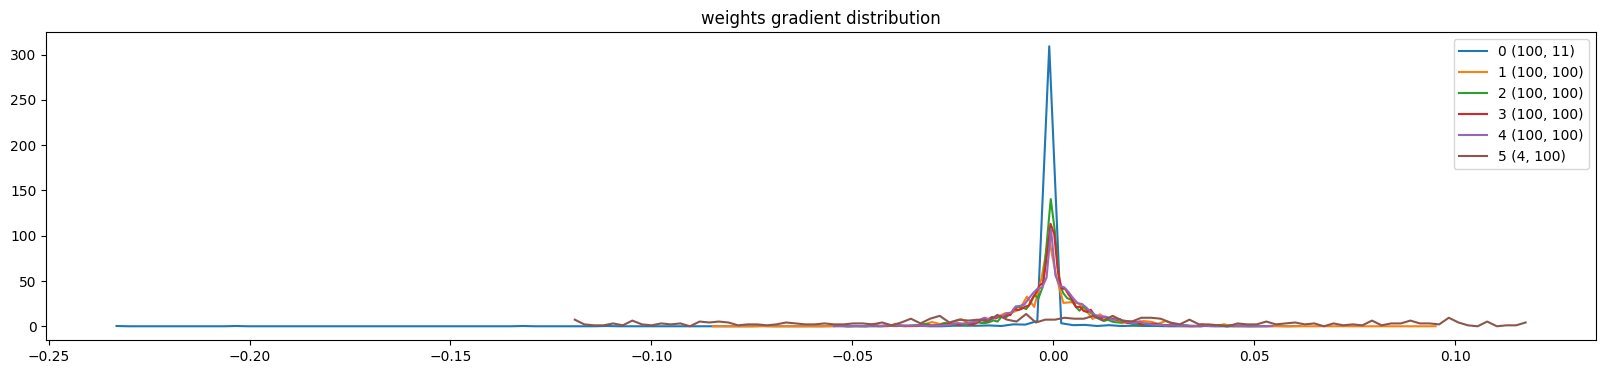

In [17]:
plt.figure(figsize=(20, 4))
legends = []

for i in range(len(linear_layer_weights)):
  p = linear_layer_weights[i]
  t = linear_layer_grads[i]
  print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
  hy, hx = torch.histogram(t, density=True)
  plt.plot(hx[:-1].detach(), hy.detach())
  legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

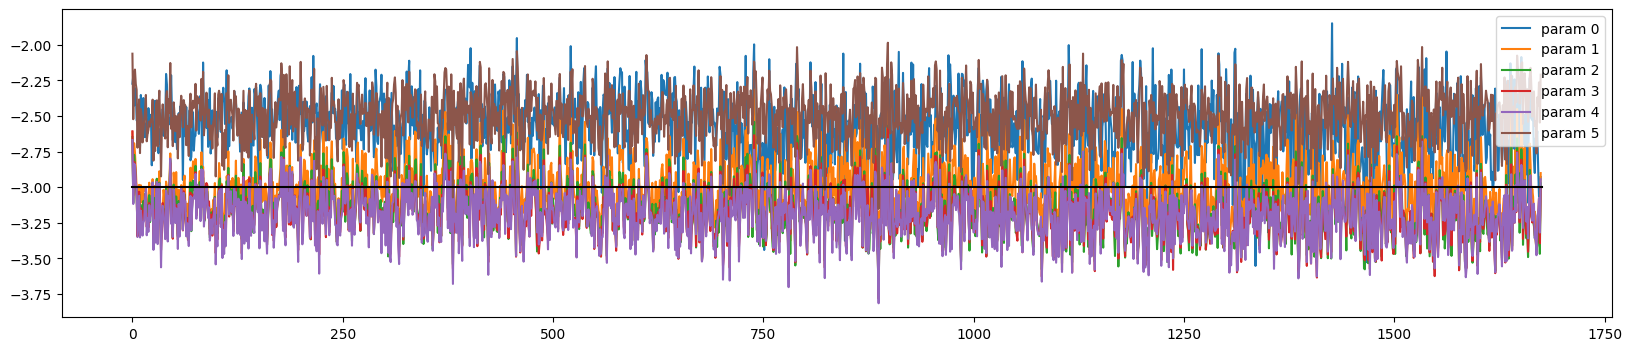

In [18]:
plt.figure(figsize=(20, 4))
legends = []

for i in range(len(ud[0])):
  plt.plot([ud[j][i] for j in range(len(ud))])
  legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # ratios should be ~1e-3, indicate on plot
plt.legend(legends);